In [1]:
import os
import string
import nltk
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from numpy.linalg import inv

# Document corpus
#### For the sake of initial implementation and correctness check, we will implement a small **document corpus**, consisting of three original texts, and three plagiarisations of various degress.

#### This will later be chnaged into large corpus loading.

#### **NOTE**: LSA does not require labeling, and will process documents as if they're the same. It is here for the comfort of testing. Also, SVD and cosine similarity will later be implemented **MANUALLY**, this is a test version.

In [2]:
def create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)

def write_file(filepath, content):
    with open(filepath, 'w', encoding='utf-8') as f:
        f.write(content)

def main():
    base_dir = "corpus"
    originals_dir = os.path.join(base_dir, "originals")
    plagiarism_dir = os.path.join(base_dir, "plagiarism")
    create_directory(originals_dir)
    create_directory(plagiarism_dir)

    original_texts = {
        "original1.txt": (
            "In recent years, the rapid advancements in artificial intelligence have revolutionized many sectors of the economy. "
            "The development of machine learning algorithms has led to significant improvements in data analysis, predictive modeling, and automation. "
            "This transformative wave is not only enhancing efficiency but also opening up new avenues for innovation."
        ),
        "original2.txt": (
            "The natural world is facing unprecedented challenges due to climate change and human activity. "
            "Scientists continue to study the intricate balance of ecosystems, striving to understand how flora and fauna adapt to shifting environmental conditions. "
            "Such research is critical for devising strategies to mitigate environmental degradation."
        ),
        "original3.txt": (
            "Literature has long served as a mirror to society, reflecting its values, conflicts, and dreams. "
            "Through a diverse range of narratives, authors explore the complexities of human nature and the eternal struggle between hope and despair. "
            "These stories continue to inspire readers across generations."
        ),
        "original4.txt": (
            "Dogs are very curious creatures, often jumping around and looking for new fun corners to inhabitate."
        ),
    }
    
    for filename, text in original_texts.items():
        filepath = os.path.join(originals_dir, filename)
        write_file(filepath, text)
    
    plagiarism_texts = {
        "plagiarism1.txt": (
            "In recent years, the rapid developments in artificial intelligence have revolutionized various sectors of the economy. "
            "The progress in machine learning algorithms has resulted in notable improvements in data analysis, predictive modeling, and automation. "
            "This transformative trend is not only boosting efficiency but also opening up new avenues for innovation."
        ),
        "plagiarism2.txt": (
            "Human activity and climate change are imposing unprecedented strains on the natural environment. "
            "Researchers are deeply engaged in exploring the delicate balance of ecosystems, aiming to uncover how plants and animals adjust to changing environmental conditions. "
            "This line of inquiry is essential for developing effective measures to prevent further ecological damage."
        ),
        "plagiarism3.txt": (
            "For centuries, literature has reflected the ethos of society, mirroring its values, struggles, and aspirations. "
            "Through various forms of storytelling, writers delve into the intricacies of human behavior and the persistent battle between optimism and sorrow. "
            "These narratives continue to captivate audiences across time."
        ),
        "plagiarism4.txt": (
            "Owners of dogs showcase great concern for fur consistency, visiting vets and other specialists."
        ),
    }

    for filename, text in plagiarism_texts.items():
        filepath = os.path.join(plagiarism_dir, filename)
        write_file(filepath, text)
    print("Corpus created successfully.")

if __name__ == "__main__":
    main()

Corpus created successfully.


# Document preprocessing

#### The next step is **document preprocessing**. In this snippet, the script reads each text file from the corpus, converts the text to lowercase, removes punctuation, tokenizes it into words, filters out common English stop words, and applies **lemmatization** to reduce words to their base forms. The preprocessed output is then saved in a separate directory structure.

#### Lemmatization, essentially, is the process of grouping together different inflected forms of the same word. For example, `{was}` -> (to) be, `{building, builder}` -> build.

In [3]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

def process_corpus(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for filename in os.listdir(input_dir):
        if filename.endswith('.txt'):
            file_path = os.path.join(input_dir, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()
            tokens = preprocess_text(text)
            processed_text = ' '.join(tokens)
            output_path = os.path.join(output_dir, filename)
            with open(output_path, 'w', encoding='utf-8') as outfile:
                outfile.write(processed_text)
            print(f"Processed {filename}")

def main():
    corpus_dir = "corpus"
    processed_dir = "processed"
    categories = ["originals", "plagiarism"]
    
    for category in categories:
        input_category_dir = os.path.join(corpus_dir, category)
        output_category_dir = os.path.join(processed_dir, category)
        process_corpus(input_category_dir, output_category_dir)

if __name__ == "__main__":
    main()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Processed original1.txt
Processed original2.txt
Processed original3.txt
Processed original4.txt
Processed plagiarism1.txt
Processed plagiarism2.txt
Processed plagiarism3.txt
Processed plagiarism4.txt


# Visualizing:

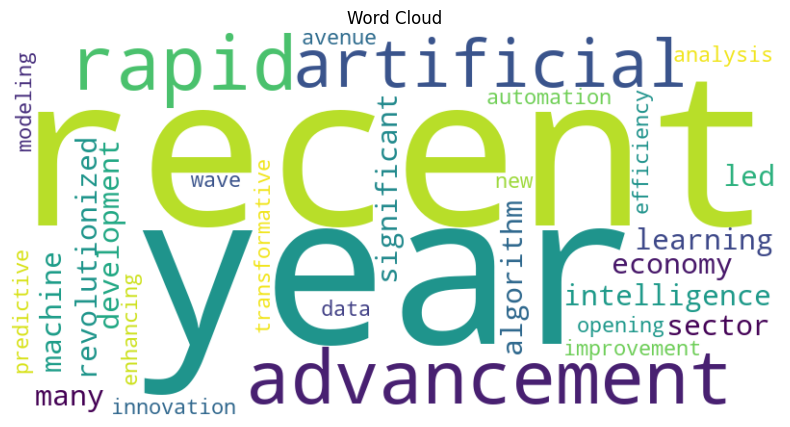

In [4]:
def visualize_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Word Cloud")
    plt.show()

def main():
    processed_file = os.path.join("processed", "originals", "original1.txt")
    if os.path.exists(processed_file):
        with open(processed_file, 'r', encoding='utf-8') as f:
            processed_text = f.read()
        visualize_wordcloud(processed_text)
    else:
        print(f"{processed_file} not found. Make sure the preprocessing step has been executed.")

if __name__ == "__main__":
    main()

# Matrix creation and TF-IDF

#### The next step takes the preprocessed texts and converts them into a term-document matrix using TF-IDF weighting. In this snoppet, we load all the processed documents, create a corpus, and then uses scikit-learn's `TfidfVectorizer` to compute the **TF-IDF matrix**.

In [5]:
def load_processed_documents(base_dir="processed"):
    documents = []
    doc_names = []
    for category in ["originals", "plagiarism"]:
        category_path = os.path.join(base_dir, category)
        for filename in os.listdir(category_path):
            if filename.endswith(".txt"):
                file_path = os.path.join(category_path, filename)
                with open(file_path, "r", encoding="utf-8") as file:
                    content = file.read()
                    documents.append(content)
                    doc_names.append(f"{category}/{filename}")
    return documents, doc_names

def create_tfidf_matrix(documents):
    vectorizer = TfidfVectorizer()
    #Compute the TF-IDF matrix (each row corresponds to a document,
    #each column corresponds to a unique term)
    tfidf_matrix = vectorizer.fit_transform(documents)
    return tfidf_matrix, vectorizer

def display_matrix_info(tfidf_matrix, vectorizer, doc_names, verbose=True):
    df = pd.DataFrame(tfidf_matrix.toarray(), index=doc_names, columns=vectorizer.get_feature_names_out())
    if verbose:
        print("TF-IDF Matrix Shape:", tfidf_matrix.shape)
    print("\nTF-IDF Matrix (first 5 rows and 10 columns):")
    print(df.iloc[:, :10])
    
def main():
    documents, doc_names = load_processed_documents()
    tfidf_matrix, vectorizer = create_tfidf_matrix(documents)
    display_matrix_info(tfidf_matrix, vectorizer, doc_names)

if __name__ == "__main__":
    main()

TF-IDF Matrix Shape: (8, 152)

TF-IDF Matrix (first 5 rows and 10 columns):
                              across  activity   adapt    adjust  advancement  \
originals/original1.txt     0.000000  0.000000  0.0000  0.000000     0.206813   
originals/original2.txt     0.000000  0.157391  0.1878  0.000000     0.000000   
originals/original3.txt     0.170578  0.000000  0.0000  0.000000     0.000000   
originals/original4.txt     0.000000  0.000000  0.0000  0.000000     0.000000   
plagiarism/plagiarism1.txt  0.000000  0.000000  0.0000  0.000000     0.000000   
plagiarism/plagiarism2.txt  0.000000  0.153722  0.0000  0.183422     0.000000   
plagiarism/plagiarism3.txt  0.171639  0.000000  0.0000  0.000000     0.000000   
plagiarism/plagiarism4.txt  0.000000  0.000000  0.0000  0.000000     0.000000   

                              aiming  algorithm      also  analysis    animal  
originals/original1.txt     0.000000   0.173325  0.173325  0.173325  0.000000  
originals/original2.txt     0.0000

# Core Latent Semantic Analysis

#### We start by computing **singular value decomposition (SVD)**, - a factorization of a real or complex matrix into a rotation, followed by a rescaling followed by another rotation. It generalizes the eigendecomposition of a square normal matrix with an orthonormal eigenbasis to any `m * n`⁠ matrix. In this sample, we use scikit-learn's `TruncatedSVD` to reduce the dimensionality of our TF-IDF matrix. We also plot the cumulative explained variance to visually determine an appropriate cutoff, for the sake of choosing an optimal `k`.

#### For ease of use, SVD can be implemented like an object, imitating the behaviour of scikit SVD:

In [6]:
class ManualSVD:
    def __init__(self, U_k, Sigma_k, Vt_k, singular_values):
        self.U_k = U_k
        self.Sigma_k = Sigma_k
        self.Vt_k = Vt_k
        self.components_ = Vt_k
        self.singular_values_ = singular_values

def manual_svd(tfidf_matrix, k):
    A = tfidf_matrix.toarray()
    U, sigma_vals, Vt = np.linalg.svd(A, full_matrices=False)

    U_k = U[:, :k]
    Sigma_k = np.diag(sigma_vals[:k])
    Vt_k = Vt[:k, :]

    reduced_matrix = np.dot(U_k, Sigma_k)
    svd_model = ManualSVD(U_k, Sigma_k, Vt_k, sigma_vals[:k])
    return reduced_matrix, svd_model


TF-IDF Matrix Shape: (8, 152)


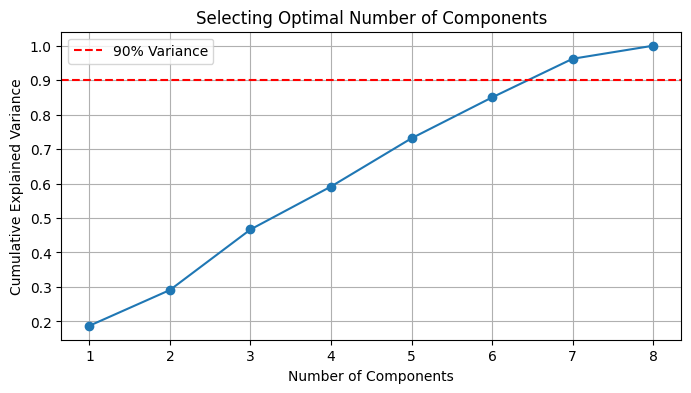

Optimal number of components: 7
Reduced matrix shape: (8, 7)

Reduced Document Matrix (first 5 rows):
                                   0         1         2         3         4  \
originals/original1.txt     0.933072 -0.020837 -0.026594 -0.036214  0.028492   
originals/original2.txt     0.003214  0.682713 -0.399681 -0.000838  0.000065   
originals/original3.txt     0.011803  0.448224  0.636621  0.005946 -0.004493   
originals/original4.txt     0.085008 -0.003573 -0.007217  0.721296 -0.687334   
plagiarism/plagiarism1.txt  0.933897 -0.007910 -0.006105 -0.035944  0.028337   

                                   5         6  
originals/original1.txt    -0.027421  0.001249  
originals/original2.txt     0.000632  0.611675  
originals/original3.txt    -0.626837 -0.025901  
originals/original4.txt     0.003489 -0.000117  
plagiarism/plagiarism1.txt  0.007687 -0.000423  


In [7]:
def choose_optimal_components(tfidf_matrix, variance_threshold=0.9, max_components=100, verbose=True):
    svd = TruncatedSVD(n_components=max_components, random_state=42)
    svd.fit(tfidf_matrix)
    
    cumulative_variance = np.cumsum(svd.explained_variance_ratio_)
    optimal_k = np.argmax(cumulative_variance >= variance_threshold) + 1

    if verbose:
        #Visualization of cumulative explained variance
        plt.figure(figsize=(8, 4))
        plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
        plt.axhline(y=variance_threshold, color='red', linestyle='--', label=f'{variance_threshold*100:.0f}% Variance')
        plt.xlabel("Number of Components")
        plt.ylabel("Cumulative Explained Variance")
        plt.title("Selecting Optimal Number of Components")
        plt.legend()
        plt.grid(True)
        plt.show()
        print(f"Optimal number of components: {optimal_k}")
    return optimal_k

def perform_lsa(tfidf_matrix, optimal_k):
    svd = TruncatedSVD(n_components=optimal_k, random_state=42)
    reduced_matrix = svd.fit_transform(tfidf_matrix)
    print("Reduced matrix shape:", reduced_matrix.shape)
    return reduced_matrix, svd

def main():
    documents, doc_names = load_processed_documents()
    tfidf_matrix, vectorizer = create_tfidf_matrix(documents)
    print("TF-IDF Matrix Shape:", tfidf_matrix.shape)
    optimal_k = choose_optimal_components(tfidf_matrix, variance_threshold=0.9, max_components=50)
    reduced_matrix, svd_model = perform_lsa(tfidf_matrix, optimal_k)
    df = pd.DataFrame(reduced_matrix, index=doc_names)
    print("\nReduced Document Matrix (first 5 rows):")
    print(df.head())

if __name__ == "__main__":
    main()

# Cosine Similarity

#### We proceed with computing the **similarity scores** among documents in the reduced-dimensional space produced by LSA. We’ll use cosine similarity, which is a common measure for text similarity.
#### The key idea:

- We already have a `reduced_matrix` from the LSA step, where each row corresponds to one document in the corpus, and each column is a latent semantic dimension.

- We also have a **list of document names** (or paths) in `doc_names` that align with the rows of `reduced_matrix`.

- We can calculate **pairwise similarities** among all documents and then check which pairs exceed a chosen threshold.

In [8]:
def pairwise_document_similarity(reduced_matrix, doc_names):
    sim_matrix = cosine_similarity(reduced_matrix)
    df_sim = pd.DataFrame(sim_matrix, index=doc_names, columns=doc_names)
    return df_sim

def transform_query(query_text, vectorizer, svd_model):
    query_tfidf = vectorizer.transform([query_text])
    query_lsa = svd_model.transform(query_tfidf)
    return query_lsa

def compare_query_to_corpus(query_vector, corpus_vectors, doc_names):
    sims = cosine_similarity(query_vector, corpus_vectors)[0]
    results = sorted(zip(doc_names, sims), key=lambda x: x[1], reverse=True)
    return results

#Main Integrated Pipeline

def main():
    #1. Load the processed documents
    documents, doc_names = load_processed_documents()
    
    #2. Create the TF-IDF weighted term-document matrix
    tfidf_matrix, vectorizer = create_tfidf_matrix(documents)
    print("TF-IDF Matrix Shape:", tfidf_matrix.shape)
    
    #3. Choose the optimal number of SVD components (LSA dimensions)
    optimal_k = choose_optimal_components(tfidf_matrix, variance_threshold=0.9, max_components=50, verbose=False)
    
    #4. Perform LSA (SVD) to reduce dimensionality
    reduced_matrix, svd_model = perform_lsa(tfidf_matrix, optimal_k)
    
    #5. Compute pairwise cosine similarities between all documents
    df_sim = pairwise_document_similarity(reduced_matrix, doc_names)
    print("\nPairwise Cosine Similarity Matrix:\n", df_sim)

    similarities = []
    for i in range(len(doc_names)):
        for j in range(i + 1, len(doc_names)):
            similarities.append((doc_names[i], doc_names[j], df_sim.iloc[i, j]))
    similarities.sort(key=lambda x: x[2], reverse=True)
    
    print("\nTop Document Pairs by Similarity:")
    for doc_a, doc_b, sim_score in similarities:
        print(f"{doc_a} vs {doc_b}: {sim_score:.4f}")
    
    #6. Compare a sample query document to the corpus (output below pairwise results from the corpus)
    query_text = "Artificial intelligence has dramatically transformed data analysis and automation."
    query_vector = transform_query(query_text, vectorizer, svd_model)
    query_results = compare_query_to_corpus(query_vector, reduced_matrix, doc_names)
    
    print("\nQuery Similarity Results:")
    for doc, sim in query_results:
        print(f"{doc}: {sim:.4f}")

if __name__ == "__main__":
    main()

TF-IDF Matrix Shape: (8, 152)
Reduced matrix shape: (8, 7)

Pairwise Cosine Similarity Matrix:
                             originals/original1.txt  originals/original2.txt  \
originals/original1.txt                    1.000000             1.929909e-04   
originals/original2.txt                    0.000193             1.000000e+00   
originals/original3.txt                    0.001664             3.535762e-02   
originals/original4.txt                    0.036124             6.021690e-08   
plagiarism/plagiarism1.txt                 0.998958            -1.931869e-04   
plagiarism/plagiarism2.txt                 0.000019             2.557940e-01   
plagiarism/plagiarism3.txt                -0.005851             3.559166e-02   
plagiarism/plagiarism4.txt                 0.000004            -5.670772e-09   

                            originals/original3.txt  originals/original4.txt  \
originals/original1.txt                1.664188e-03             3.612382e-02   
originals/original2.txt

#### *Alternatively, we can now use our corpus to compare two queries between themselves:*

In [9]:
def compare_two_texts(text1, text2, vectorizer, svd_model):
    """
    Compares two texts using the trained TF-IDF vectorizer and SVD (LSA) model.
    This function uses the models trained on your corpus to transform the two texts into
    the same semantic space and computes the cosine similarity between them.
    
    Parameters:
      text1 (str): The first text (e.g., the original document).
      text2 (str): The second text (e.g., a document that may be plagiarizing the first).
      vectorizer (TfidfVectorizer): A fitted TF-IDF vectorizer from your training step.
      svd_model (TruncatedSVD): A fitted TruncatedSVD model from your LSA step.
    
    Returns:
      similarity (float): The cosine similarity score between the two texts.
    """
    #Create a mini-corpus with both texts.
    corpus = [text1, text2]
    
    tfidf_matrix = vectorizer.transform(corpus)
    reduced_matrix = svd_model.transform(tfidf_matrix)
    similarity = cosine_similarity(
        reduced_matrix[0].reshape(1, -1),
        reduced_matrix[1].reshape(1, -1)
    )[0][0]
    
    return similarity

if __name__ == "__main__":
    text1 = (
        "In recent years, the rapid advancements in artificial intelligence have revolutionized many sectors of the economy. "
        "The development of machine learning algorithms has led tdictive modeling, and automation."
    )
    text2 = (
        "Recent developments in AI have dramatically transformed numerous industries. "
        "Improvements in machine learning have boosted data analysis, prediction techniques, and automation, revolutionizing the economy."
    )

    # 1. Load the processed documents
    documents, doc_names = load_processed_documents()
    
    # 2. Create the TF-IDF weighted term-document matrix
    tfidf_matrix, vectorizer = create_tfidf_matrix(documents)
    print("TF-IDF Matrix Shape:", tfidf_matrix.shape)
    
    # 3. Choose the optimal number of SVD components (LSA dimensions)
    optimal_k = choose_optimal_components(tfidf_matrix, variance_threshold=0.9, max_components=50,verbose=False)
    
    # 4. Perform LSA (SVD) to reduce dimensionality
    reduced_matrix, svd_model = perform_lsa(tfidf_matrix, optimal_k)

    # 5. Comparing two given texts
    similarity_score = compare_two_texts(text1, text2, vectorizer, svd_model)
    print("Cosine Similarity between text1 and text2: {:.4f}".format(similarity_score))


TF-IDF Matrix Shape: (8, 152)
Reduced matrix shape: (8, 7)
Cosine Similarity between text1 and text2: 1.0000
